In [1]:
#Apply the trained models at random seed 0 (1 of the 10 re-trains), and save the output IT sshs. Plot some figures to check if they look all right.
#This applies to outputs with SSH, SST (unfiltered), and (u,v) as inputs. 
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import r2_score as R2
from sklearn.model_selection import KFold
from copy import deepcopy
import utils
from unet import UNet_nobatchnorm
from scipy.stats import pearsonr
from pathlib import Path
import numpy.fft as fft
from matplotlib.colors import TwoSlopeNorm
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import helper_functions as hf

In [2]:
root_dir = '/work/uo0780/u241359/project_tide_synergy/data/'
nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)
Ntrain = np.sum([nc.dimensions['time_counter'].size for nc in nctrains], axis = 0)
Ntest = np.sum([nc.dimensions['time_counter'].size for nc in nctest], axis = 0)

model_folder = '/work/uo0780/u241359/project_tide_synergy/trainedmodels_forpaper/'
filesuffix='_ssh_cosssh_sin_nobatchnorm_rp_0.pth'

vel_cmap  = 'BrBG' #'viridis'
vort_cmap = 'PRGn'
ssh_cmap  = 'bwr'
sst_cmap = 'inferno'

bottom_slice = slice(0,256)
mid_slice = slice(232, 488)
top_slice = slice(464, 720)

def corr(data, mod):
    return pearsonr(data.flatten(), mod.flatten())[0]
def L2_R(data,mod):
    return R2(data.flatten(), mod.flatten())
def performance_metrics(data, mod):
    return corr(data, mod), L2_R(data,mod)

In [3]:
Nbase = 16
def totorch(x):
    return torch.tensor(x, dtype = torch.float).cpu()
    
def preload_data(nctrains, total_records):
    #total_records = Ntrain#sum(nc.dimensions['time_counter'].size for nc in nctrains)
    #dimensions of data of the nc file.
    max_height = 722
    max_width = 258
    all_input_data = np.zeros((total_records, N_inp, max_height, max_width))*np.nan
    all_output_data = np.zeros((total_records, N_out, max_height, max_width))*np.nan
    current_index = 0
    for ncindex, ncdata in enumerate(nctrains):
        num_recs = ncdata.dimensions['time_counter'].size
        rec_slice = slice(current_index, current_index + num_recs)
        
        for ind, var_name in enumerate(var_input_names):
            data_slice = np.squeeze(ncdata.variables[var_name])
            # print('data_slice shape:')
            # print(data_slice.shape)        
            #all_input_data[rec_slice, ind, :, :] = data_slice
            #For some variables, the dimensions in (x, y) may be smaller than (max_height, max_width). Changing the code so that it adapts them.
            # Get the actual dimensions of data_slice
            slice_height, slice_width = data_slice.shape[-2], data_slice.shape[-1]
            # Place data_slice into the corresponding slice of all_input_data
            all_input_data[rec_slice, ind, :slice_height, :slice_width] = data_slice
    

        for ind, var_name in enumerate(var_output_names):
            data_slice = np.squeeze(ncdata.variables[var_name])
            #all_output_data[rec_slice, ind, :, :] = data_slice
            # Get the actual dimensions of data_slice
            slice_height, slice_width = data_slice.shape[-2], data_slice.shape[-1]
            # Place data_slice into the corresponding slice of all_input_data
            all_output_data[rec_slice, ind, :slice_height, :slice_width] = data_slice

        current_index += num_recs
        
    return all_input_data, all_output_data

# # Modify the loadtrain function to pull data from preloaded memory
# def loaddata_preloaded_train(index, batch_size, all_input_data, all_output_data):
#     rec_slice = slice(index, index + batch_size)
#     lim = 720
#     width = 256
#     yslice = slice(0, lim)
#     xslice = slice(0, width)
#     # print('rec_slice is:')
#     # print(rec_slice)
#     # print('mean of squared values of loaded input data:')
#     # print("{0:0.32f}".format(np.nanmean(all_input_data[rec_slice, :, yslice, xslice]**2)))
#     return (all_input_data[rec_slice, :, yslice, xslice], 
#             all_output_data[rec_slice, :, yslice, xslice])
#Load test data as one single batch
def loaddata_preloaded_test(all_input_data, all_output_data):
    #rec_slice = slice(index, index + batch_size)
    lim = 720
    width = 256
    yslice = slice(0, lim)
    xslice = slice(0, width)
    # print('rec_slice is:')
    # print(rec_slice)
    # print('mean of squared values of loaded input data:')
    # print("{0:0.32f}".format(np.nanmean(all_input_data[rec_slice, :, yslice, xslice]**2)))
    return (all_input_data[:, :, yslice, xslice], 
            all_output_data[:, :, yslice, xslice])


def load_variable(ncdata, ncindex, variable, rec_slice, yslice, xslice):
    data_squeezed = np.squeeze(ncdata[ncindex].variables[variable])
    return data_squeezed[rec_slice, yslice, xslice]

In [4]:
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
vi1 = 'ssh_ins'

vo1 = 'ssh_cos'
vo2 = 'ssh_sin'

save_fn_prefix  = 'any_{}_{}{}_nobatchnorm'.format(vi1, vo1, vo2)
var_input_names = [vi1]
var_output_names = [vo1, vo2]
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
N_inp = len(var_input_names)
N_out = len(var_output_names)

nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)

all_train_input, all_train_output = preload_data(nctrains, Ntrain)
all_test_input, all_test_output = preload_data(nctest, Ntest)

#Normalize data
#Compute mean and variance for normalization
mean_input=np.nanmean(np.concatenate((all_train_input, all_test_input), axis=0),axis=(0, 2, 3))
mean_output=np.nanmean(np.concatenate((all_train_output, all_test_output), axis=0),axis=(0, 2, 3))
#Subtract the data with their means
all_train_input=all_train_input-mean_input[None, :, None, None]
all_train_output=all_train_output-mean_output[None, :, None, None]
all_test_input=all_test_input-mean_input[None, :, None, None]
all_test_output=all_test_output-mean_output[None, :, None, None]
#Compute the variances
var_input=np.nanmean((np.concatenate((all_train_input, all_test_input), axis=0))**2,axis=(0, 2, 3))
var_output=np.nanmean((np.concatenate((all_train_output, all_test_output), axis=0))**2,axis=(0, 2, 3))
print("mean and variance of all input data:")
print(mean_input,var_input)
print("mean and variance of all output data:")
print(mean_output,var_output)
#Scale the data so that they have variance of 1
all_train_input=all_train_input/np.sqrt(var_input[None, :, None, None])
all_train_output=all_train_output/np.sqrt(var_output[None, :, None, None])
all_test_input=all_test_input/np.sqrt(var_input[None, :, None, None])
all_test_output=all_test_output/np.sqrt(var_output[None, :, None, None])

combined_names = ''.join(var_input_names)
model_filename = 'any_'+combined_names+filesuffix
model_path = Path(model_folder, model_filename)
state_dict = torch.load(model_path)

# Create a new instance of the model
model = UNet_nobatchnorm(N_inp, N_out, bilinear = True, Nbase = Nbase)
# Load the state_dict into the model
model.load_state_dict(state_dict)
# Set the model to evaluation mode
model.eval()

inp_test, out_test = loaddata_preloaded_test(all_test_input, all_test_output)
with torch.no_grad():
    out_mod = model(totorch(inp_test)).detach().cpu().numpy()
#Renormalize
out_mod = out_mod*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
out_test = out_test*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
inp_test = inp_test*np.sqrt(var_input[None, :, None, None])+mean_input[None, :, None, None]

truth_bot = out_test[:, :, bottom_slice, :]
truth_mid = out_test[:, :, mid_slice, :]
truth_top = out_test[:, :, top_slice, :]

mod_bot = out_mod[:, :, bottom_slice, :]
mod_mid = out_mod[:, :, mid_slice, :]
mod_top = out_mod[:, :, top_slice, :]

print (performance_metrics(out_test, out_mod), 'total panel')
print (performance_metrics(truth_bot, mod_bot), 'bottom  panel')
print (performance_metrics(truth_mid, mod_mid), 'mid  panel')
print (performance_metrics(truth_top, mod_top), 'top  panel')
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
H_out_mod = out_mod
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑


mean and variance of all input data:
[0.03307104] [0.3119807]
mean and variance of all output data:
[-5.16228102e-04 -9.83592627e-05] [9.36516511e-05 1.01456128e-04]
(0.7922880990302599, 0.6257853291529903) total panel
(0.9714905786178775, 0.9432381197716873) bottom  panel
(0.6838707258738191, 0.46327007799628683) mid  panel
(0.7132047882514836, 0.4959358989798468) top  panel


In [5]:
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
vi1 = 'ssh_ins'
vi2 = 'T_xy_ins'
vi3 = 'u_xy_ins'
vi4 = 'v_xy_ins'

vo1 = 'ssh_cos'
vo2 = 'ssh_sin'

save_fn_prefix  = 'any_{}{}{}{}_{}{}_nobatchnorm'.format(vi1, vi2, vi3, vi4, vo1, vo2)
var_input_names = [vi1, vi2, vi3, vi4]
var_output_names = [vo1, vo2]
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

N_inp = len(var_input_names)
N_out = len(var_output_names)

nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)

all_train_input, all_train_output = preload_data(nctrains, Ntrain)
all_test_input, all_test_output = preload_data(nctest, Ntest)

#Normalize data
#Compute mean and variance for normalization
mean_input=np.nanmean(np.concatenate((all_train_input, all_test_input), axis=0),axis=(0, 2, 3))
mean_output=np.nanmean(np.concatenate((all_train_output, all_test_output), axis=0),axis=(0, 2, 3))
#Subtract the data with their means
all_train_input=all_train_input-mean_input[None, :, None, None]
all_train_output=all_train_output-mean_output[None, :, None, None]
all_test_input=all_test_input-mean_input[None, :, None, None]
all_test_output=all_test_output-mean_output[None, :, None, None]
#Compute the variances
var_input=np.nanmean((np.concatenate((all_train_input, all_test_input), axis=0))**2,axis=(0, 2, 3))
var_output=np.nanmean((np.concatenate((all_train_output, all_test_output), axis=0))**2,axis=(0, 2, 3))
print("mean and variance of all input data:")
print(mean_input,var_input)
print("mean and variance of all output data:")
print(mean_output,var_output)
#Scale the data so that they have variance of 1
all_train_input=all_train_input/np.sqrt(var_input[None, :, None, None])
all_train_output=all_train_output/np.sqrt(var_output[None, :, None, None])
all_test_input=all_test_input/np.sqrt(var_input[None, :, None, None])
all_test_output=all_test_output/np.sqrt(var_output[None, :, None, None])

combined_names = ''.join(var_input_names)
model_filename = 'any_'+combined_names+filesuffix
model_path = Path(model_folder, model_filename)
state_dict = torch.load(model_path)

# Create a new instance of the model
model = UNet_nobatchnorm(N_inp, N_out, bilinear = True, Nbase = Nbase)
# Load the state_dict into the model
model.load_state_dict(state_dict)
# Set the model to evaluation mode
model.eval()

inp_test, out_test = loaddata_preloaded_test(all_test_input, all_test_output)
with torch.no_grad():
    out_mod = model(totorch(inp_test)).detach().cpu().numpy()
#Renormalize
out_mod = out_mod*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
out_test = out_test*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
inp_test = inp_test*np.sqrt(var_input[None, :, None, None])+mean_input[None, :, None, None]

truth_bot = out_test[:, :, bottom_slice, :]
truth_mid = out_test[:, :, mid_slice, :]
truth_top = out_test[:, :, top_slice, :]

mod_bot = out_mod[:, :, bottom_slice, :]
mod_mid = out_mod[:, :, mid_slice, :]
mod_top = out_mod[:, :, top_slice, :]

print (performance_metrics(out_test, out_mod), 'total panel')
print (performance_metrics(truth_bot, mod_bot), 'bottom  panel')
print (performance_metrics(truth_mid, mod_mid), 'mid  panel')
print (performance_metrics(truth_top, mod_top), 'top  panel')
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
HUT_out_mod = out_mod
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑


mean and variance of all input data:
[ 3.30710389e-02  2.51429352e+01  3.56612545e-02 -1.90587743e-03] [0.3119807  0.34119618 0.04679374 0.04875586]
mean and variance of all output data:
[-5.16228102e-04 -9.83592627e-05] [9.36516511e-05 1.01456128e-04]
(0.9744307895407879, 0.9491410852362288) total panel
(0.9959517526491225, 0.9898062007008107) bottom  panel
(0.9593653251639166, 0.9195938188902606) mid  panel
(0.979366368020925, 0.9576397515804225) top  panel


2880


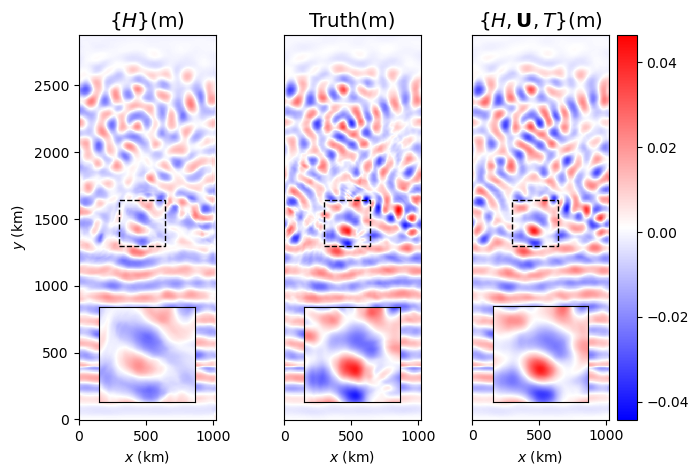

In [6]:
snap_index = 100
HUT_wave = HUT_out_mod[snap_index,0,:, : ]
H_wave = H_out_mod[snap_index,0,:, : ]
true_wave = out_test[snap_index,0,:, : ]

ny, nx = np.shape(H_wave)
dx = 4
Lx = nx*dx
Ly = ny*dx
print (Ly)

x_axis = np.arange(0, Lx, dx)
y_axis = np.arange(0, Ly, dx)
extent = [np.min(x_axis), np.max(x_axis), np.min(y_axis), np.max(y_axis)]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize = (7.5,5))

clims = (np.min(true_wave), np.max(true_wave))

im1 = ax1.pcolor(x_axis, y_axis, H_wave, cmap=ssh_cmap, clim =clims)
ax1.set_title(r'$\{H\}$(m)',fontsize ='x-large')
# fig.colorbar(im1, ax = ax1)

im2 = ax2.pcolor(x_axis, y_axis, true_wave, cmap=ssh_cmap, clim =clims)
ax2.set_title('Truth(m)',fontsize ='x-large')
# fig.colorbar(im2, ax = ax2)

ax2.get_yaxis().set_visible(False)

im3 = ax3.pcolor(x_axis, y_axis, HUT_wave, cmap=ssh_cmap, clim =clims)
ax3.set_title(r'$\{H,\mathbf{U},T\}$(m)',fontsize ='x-large')
fig.colorbar(im1, ax = ax3)
ax3.get_yaxis().set_visible(False)

# rect_orig = (78, 65)
# rect_size = 80
zoom_x1, zoom_x2 = 75, 160  # Example coordinates for zoomed-in section
zoom_y1, zoom_y2 = 325, 410

extent = [zoom_x1, zoom_x2, zoom_y1, zoom_y2]
zoom_width = "70%"
# Create an inset axis within ax1 for the zoomed-in section
axins = inset_axes(ax2, width=zoom_width, height=zoom_width, loc='lower center',\
                   borderpad=-5.0)
im_zoomed = axins.imshow(true_wave[zoom_y1:zoom_y2, zoom_x1:zoom_x2],
                         origin='lower', cmap=ssh_cmap, clim=clims)
# axins.set_title('Zoomed-In')
axins.set_xticks([])
axins.set_yticks([])
# axins.set_position([0.2, 0.2, 0.3, 0.3])

axins = inset_axes(ax3, width=zoom_width, height=zoom_width, loc='lower center',\
                   borderpad=-5.0)
im_zoomed = axins.imshow(HUT_wave[zoom_y1:zoom_y2, zoom_x1:zoom_x2],
                         origin='lower', cmap=ssh_cmap, clim=clims)
# axins.set_title('Zoomed-In')
axins.set_xticks([])
axins.set_yticks([])
# axins.set_position([0.2, 0.2, 0.3, 0.3])
# axins.text(25., 8., 'ghost', color='k', ha='center', va='center', fontsize=12)


axins = inset_axes(ax1, width=zoom_width, height=zoom_width, loc='lower center',\
                   borderpad=-5.0)
im_zoomed = axins.imshow(H_wave[zoom_y1:zoom_y2, zoom_x1:zoom_x2],
                         origin='lower', cmap=ssh_cmap, clim=clims)
# axins.set_title('Zoomed-In')
axins.set_xticks([])
axins.set_yticks([])
# axins.set_position([0.2, 0.2, 0.3, 0.3])
zoomed_region1 = patches.Rectangle((x_axis[zoom_x1], y_axis[zoom_y1]), x_axis[zoom_x2] - x_axis[zoom_x1], 
                                   y_axis[zoom_y2] - y_axis[zoom_y1],
                          edgecolor='k', facecolor='none', linewidth=1, linestyle='--')
zoomed_region2 = patches.Rectangle((x_axis[zoom_x1], y_axis[zoom_y1]), x_axis[zoom_x2] - x_axis[zoom_x1], 
                                   y_axis[zoom_y2] - y_axis[zoom_y1],
                          edgecolor='k', facecolor='none', linewidth=1, linestyle='--')
zoomed_region3 = patches.Rectangle((x_axis[zoom_x1], y_axis[zoom_y1]), x_axis[zoom_x2] - x_axis[zoom_x1], 
                                   y_axis[zoom_y2] - y_axis[zoom_y1],
                          edgecolor='k', facecolor='none', linewidth=1, linestyle='--')
ax1.add_patch(zoomed_region1)
ax2.add_patch(zoomed_region2)
ax3.add_patch(zoomed_region3)

ax1.set_xlabel(r'$x$ (km)') 
ax1.set_ylabel(r'$y$ (km)') 
ax2.set_xlabel(r'$x$ (km)') 
ax3.set_xlabel(r'$x$ (km)') 

ax1.set_aspect(1)
ax2.set_aspect(1)
ax3.set_aspect(1)

plt.show()

In [7]:
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
vi1 = 'T_xy_ins'

vo1 = 'ssh_cos'
vo2 = 'ssh_sin'

save_fn_prefix  = 'any_{}_{}{}_nobatchnorm'.format(vi1, vo1, vo2)
var_input_names = [vi1]
var_output_names = [vo1, vo2]
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
N_inp = len(var_input_names)
N_out = len(var_output_names)

nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)

all_train_input, all_train_output = preload_data(nctrains, Ntrain)
all_test_input, all_test_output = preload_data(nctest, Ntest)

#Normalize data
#Compute mean and variance for normalization
mean_input=np.nanmean(np.concatenate((all_train_input, all_test_input), axis=0),axis=(0, 2, 3))
mean_output=np.nanmean(np.concatenate((all_train_output, all_test_output), axis=0),axis=(0, 2, 3))
#Subtract the data with their means
all_train_input=all_train_input-mean_input[None, :, None, None]
all_train_output=all_train_output-mean_output[None, :, None, None]
all_test_input=all_test_input-mean_input[None, :, None, None]
all_test_output=all_test_output-mean_output[None, :, None, None]
#Compute the variances
var_input=np.nanmean((np.concatenate((all_train_input, all_test_input), axis=0))**2,axis=(0, 2, 3))
var_output=np.nanmean((np.concatenate((all_train_output, all_test_output), axis=0))**2,axis=(0, 2, 3))
print("mean and variance of all input data:")
print(mean_input,var_input)
print("mean and variance of all output data:")
print(mean_output,var_output)
#Scale the data so that they have variance of 1
all_train_input=all_train_input/np.sqrt(var_input[None, :, None, None])
all_train_output=all_train_output/np.sqrt(var_output[None, :, None, None])
all_test_input=all_test_input/np.sqrt(var_input[None, :, None, None])
all_test_output=all_test_output/np.sqrt(var_output[None, :, None, None])

combined_names = ''.join(var_input_names)
model_filename = 'any_'+combined_names+filesuffix
model_path = Path(model_folder, model_filename)
state_dict = torch.load(model_path)

# Create a new instance of the model
model = UNet_nobatchnorm(N_inp, N_out, bilinear = True, Nbase = Nbase)
# Load the state_dict into the model
model.load_state_dict(state_dict)
# Set the model to evaluation mode
model.eval()

inp_test, out_test = loaddata_preloaded_test(all_test_input, all_test_output)
with torch.no_grad():
    out_mod = model(totorch(inp_test)).detach().cpu().numpy()
#Renormalize
out_mod = out_mod*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
out_test = out_test*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
inp_test = inp_test*np.sqrt(var_input[None, :, None, None])+mean_input[None, :, None, None]

truth_bot = out_test[:, :, bottom_slice, :]
truth_mid = out_test[:, :, mid_slice, :]
truth_top = out_test[:, :, top_slice, :]

mod_bot = out_mod[:, :, bottom_slice, :]
mod_mid = out_mod[:, :, mid_slice, :]
mod_top = out_mod[:, :, top_slice, :]

print (performance_metrics(out_test, out_mod), 'total panel')
print (performance_metrics(truth_bot, mod_bot), 'bottom  panel')
print (performance_metrics(truth_mid, mod_mid), 'mid  panel')
print (performance_metrics(truth_top, mod_top), 'top  panel')
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
T_out_mod = out_mod
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

mean and variance of all input data:
[25.14293517] [0.34119618]
mean and variance of all output data:
[-5.16228102e-04 -9.83592627e-05] [9.36516511e-05 1.01456128e-04]
(0.4168087496431786, 0.16493308866307566) total panel
(0.7268352786259142, 0.5160394424147938) bottom  panel
(0.03010871796408551, -0.027213047639433885) mid  panel
(0.006380612400525183, -0.015924797814690583) top  panel


In [8]:
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
vi1 = 'u_xy_ins'
vi2 = 'v_xy_ins'

vo1 = 'ssh_cos'
vo2 = 'ssh_sin'

save_fn_prefix  = 'any_{}{}_{}{}_nobatchnorm'.format(vi1, vi2, vo1, vo2)
var_input_names = [vi1, vi2]
var_output_names = [vo1, vo2]
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
N_inp = len(var_input_names)
N_out = len(var_output_names)

nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)

all_train_input, all_train_output = preload_data(nctrains, Ntrain)
all_test_input, all_test_output = preload_data(nctest, Ntest)

#Normalize data
#Compute mean and variance for normalization
mean_input=np.nanmean(np.concatenate((all_train_input, all_test_input), axis=0),axis=(0, 2, 3))
mean_output=np.nanmean(np.concatenate((all_train_output, all_test_output), axis=0),axis=(0, 2, 3))
#Subtract the data with their means
all_train_input=all_train_input-mean_input[None, :, None, None]
all_train_output=all_train_output-mean_output[None, :, None, None]
all_test_input=all_test_input-mean_input[None, :, None, None]
all_test_output=all_test_output-mean_output[None, :, None, None]
#Compute the variances
var_input=np.nanmean((np.concatenate((all_train_input, all_test_input), axis=0))**2,axis=(0, 2, 3))
var_output=np.nanmean((np.concatenate((all_train_output, all_test_output), axis=0))**2,axis=(0, 2, 3))
print("mean and variance of all input data:")
print(mean_input,var_input)
print("mean and variance of all output data:")
print(mean_output,var_output)
#Scale the data so that they have variance of 1
all_train_input=all_train_input/np.sqrt(var_input[None, :, None, None])
all_train_output=all_train_output/np.sqrt(var_output[None, :, None, None])
all_test_input=all_test_input/np.sqrt(var_input[None, :, None, None])
all_test_output=all_test_output/np.sqrt(var_output[None, :, None, None])

combined_names = ''.join(var_input_names)
model_filename = 'any_'+combined_names+filesuffix
model_path = Path(model_folder, model_filename)
state_dict = torch.load(model_path)

# Create a new instance of the model
model = UNet_nobatchnorm(N_inp, N_out, bilinear = True, Nbase = Nbase)
# Load the state_dict into the model
model.load_state_dict(state_dict)
# Set the model to evaluation mode
model.eval()

inp_test, out_test = loaddata_preloaded_test(all_test_input, all_test_output)
with torch.no_grad():
    out_mod = model(totorch(inp_test)).detach().cpu().numpy()
#Renormalize
out_mod = out_mod*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
out_test = out_test*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
inp_test = inp_test*np.sqrt(var_input[None, :, None, None])+mean_input[None, :, None, None]

truth_bot = out_test[:, :, bottom_slice, :]
truth_mid = out_test[:, :, mid_slice, :]
truth_top = out_test[:, :, top_slice, :]

mod_bot = out_mod[:, :, bottom_slice, :]
mod_mid = out_mod[:, :, mid_slice, :]
mod_top = out_mod[:, :, top_slice, :]

print (performance_metrics(out_test, out_mod), 'total panel')
print (performance_metrics(truth_bot, mod_bot), 'bottom  panel')
print (performance_metrics(truth_mid, mod_mid), 'mid  panel')
print (performance_metrics(truth_top, mod_top), 'top  panel')
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
U_out_mod = out_mod
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

mean and variance of all input data:
[ 0.03566125 -0.00190588] [0.04679374 0.04875586]
mean and variance of all output data:
[-5.16228102e-04 -9.83592627e-05] [9.36516511e-05 1.01456128e-04]
(0.9403380297069839, 0.8838489207682431) total panel
(0.9919459314085314, 0.9828804106195768) bottom  panel
(0.9018719824116628, 0.813324245330417) mid  panel
(0.9525740361778421, 0.8917171632070597) top  panel


In [9]:
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
vi1 = 'ssh_ins'
vi2 = 'T_xy_ins'

vo1 = 'ssh_cos'
vo2 = 'ssh_sin'

save_fn_prefix  = 'any_{}{}_{}{}_nobatchnorm'.format(vi1, vi2, vo1, vo2)
var_input_names = [vi1, vi2]
var_output_names = [vo1, vo2]
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
N_inp = len(var_input_names)
N_out = len(var_output_names)

nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)

all_train_input, all_train_output = preload_data(nctrains, Ntrain)
all_test_input, all_test_output = preload_data(nctest, Ntest)

#Normalize data
#Compute mean and variance for normalization
mean_input=np.nanmean(np.concatenate((all_train_input, all_test_input), axis=0),axis=(0, 2, 3))
mean_output=np.nanmean(np.concatenate((all_train_output, all_test_output), axis=0),axis=(0, 2, 3))
#Subtract the data with their means
all_train_input=all_train_input-mean_input[None, :, None, None]
all_train_output=all_train_output-mean_output[None, :, None, None]
all_test_input=all_test_input-mean_input[None, :, None, None]
all_test_output=all_test_output-mean_output[None, :, None, None]
#Compute the variances
var_input=np.nanmean((np.concatenate((all_train_input, all_test_input), axis=0))**2,axis=(0, 2, 3))
var_output=np.nanmean((np.concatenate((all_train_output, all_test_output), axis=0))**2,axis=(0, 2, 3))
print("mean and variance of all input data:")
print(mean_input,var_input)
print("mean and variance of all output data:")
print(mean_output,var_output)
#Scale the data so that they have variance of 1
all_train_input=all_train_input/np.sqrt(var_input[None, :, None, None])
all_train_output=all_train_output/np.sqrt(var_output[None, :, None, None])
all_test_input=all_test_input/np.sqrt(var_input[None, :, None, None])
all_test_output=all_test_output/np.sqrt(var_output[None, :, None, None])

combined_names = ''.join(var_input_names)
model_filename = 'any_'+combined_names+filesuffix
model_path = Path(model_folder, model_filename)
state_dict = torch.load(model_path)

# Create a new instance of the model
model = UNet_nobatchnorm(N_inp, N_out, bilinear = True, Nbase = Nbase)
# Load the state_dict into the model
model.load_state_dict(state_dict)
# Set the model to evaluation mode
model.eval()

inp_test, out_test = loaddata_preloaded_test(all_test_input, all_test_output)
with torch.no_grad():
    out_mod = model(totorch(inp_test)).detach().cpu().numpy()
#Renormalize
out_mod = out_mod*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
out_test = out_test*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
inp_test = inp_test*np.sqrt(var_input[None, :, None, None])+mean_input[None, :, None, None]

truth_bot = out_test[:, :, bottom_slice, :]
truth_mid = out_test[:, :, mid_slice, :]
truth_top = out_test[:, :, top_slice, :]

mod_bot = out_mod[:, :, bottom_slice, :]
mod_mid = out_mod[:, :, mid_slice, :]
mod_top = out_mod[:, :, top_slice, :]

print (performance_metrics(out_test, out_mod), 'total panel')
print (performance_metrics(truth_bot, mod_bot), 'bottom  panel')
print (performance_metrics(truth_mid, mod_mid), 'mid  panel')
print (performance_metrics(truth_top, mod_top), 'top  panel')
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
HT_out_mod = out_mod
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

mean and variance of all input data:
[ 0.03307104 25.14293517] [0.3119807  0.34119618]
mean and variance of all output data:
[-5.16228102e-04 -9.83592627e-05] [9.36516511e-05 1.01456128e-04]
(0.8487744678440295, 0.7193596003549763) total panel
(0.9771133104139615, 0.95327835847678) bottom  panel
(0.778298804130791, 0.6051651968120553) mid  panel
(0.7880553003463856, 0.6194795956538852) top  panel


In [10]:
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
vi1 = 'ssh_ins'
vi2 = 'u_xy_ins'
vi3 = 'v_xy_ins'

vo1 = 'ssh_cos'
vo2 = 'ssh_sin'

save_fn_prefix  = 'any_{}{}{}_{}{}_nobatchnorm'.format(vi1, vi2, vi3, vo1, vo2)
var_input_names = [vi1, vi2, vi3]
var_output_names = [vo1, vo2]
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
N_inp = len(var_input_names)
N_out = len(var_output_names)

nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)

all_train_input, all_train_output = preload_data(nctrains, Ntrain)
all_test_input, all_test_output = preload_data(nctest, Ntest)

#Normalize data
#Compute mean and variance for normalization
mean_input=np.nanmean(np.concatenate((all_train_input, all_test_input), axis=0),axis=(0, 2, 3))
mean_output=np.nanmean(np.concatenate((all_train_output, all_test_output), axis=0),axis=(0, 2, 3))
#Subtract the data with their means
all_train_input=all_train_input-mean_input[None, :, None, None]
all_train_output=all_train_output-mean_output[None, :, None, None]
all_test_input=all_test_input-mean_input[None, :, None, None]
all_test_output=all_test_output-mean_output[None, :, None, None]
#Compute the variances
var_input=np.nanmean((np.concatenate((all_train_input, all_test_input), axis=0))**2,axis=(0, 2, 3))
var_output=np.nanmean((np.concatenate((all_train_output, all_test_output), axis=0))**2,axis=(0, 2, 3))
print("mean and variance of all input data:")
print(mean_input,var_input)
print("mean and variance of all output data:")
print(mean_output,var_output)
#Scale the data so that they have variance of 1
all_train_input=all_train_input/np.sqrt(var_input[None, :, None, None])
all_train_output=all_train_output/np.sqrt(var_output[None, :, None, None])
all_test_input=all_test_input/np.sqrt(var_input[None, :, None, None])
all_test_output=all_test_output/np.sqrt(var_output[None, :, None, None])

combined_names = ''.join(var_input_names)
model_filename = 'any_'+combined_names+filesuffix
model_path = Path(model_folder, model_filename)
state_dict = torch.load(model_path)

# Create a new instance of the model
model = UNet_nobatchnorm(N_inp, N_out, bilinear = True, Nbase = Nbase)
# Load the state_dict into the model
model.load_state_dict(state_dict)
# Set the model to evaluation mode
model.eval()

inp_test, out_test = loaddata_preloaded_test(all_test_input, all_test_output)
with torch.no_grad():
    out_mod = model(totorch(inp_test)).detach().cpu().numpy()
#Renormalize
out_mod = out_mod*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
out_test = out_test*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
inp_test = inp_test*np.sqrt(var_input[None, :, None, None])+mean_input[None, :, None, None]

truth_bot = out_test[:, :, bottom_slice, :]
truth_mid = out_test[:, :, mid_slice, :]
truth_top = out_test[:, :, top_slice, :]

mod_bot = out_mod[:, :, bottom_slice, :]
mod_mid = out_mod[:, :, mid_slice, :]
mod_top = out_mod[:, :, top_slice, :]

print (performance_metrics(out_test, out_mod), 'total panel')
print (performance_metrics(truth_bot, mod_bot), 'bottom  panel')
print (performance_metrics(truth_mid, mod_mid), 'mid  panel')
print (performance_metrics(truth_top, mod_top), 'top  panel')
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
HU_out_mod = out_mod
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

mean and variance of all input data:
[ 0.03307104  0.03566125 -0.00190588] [0.3119807  0.04679374 0.04875586]
mean and variance of all output data:
[-5.16228102e-04 -9.83592627e-05] [9.36516511e-05 1.01456128e-04]
(0.9552972413948543, 0.9125788377717431) total panel
(0.9921988314635113, 0.9831651789388557) bottom  panel
(0.9253126751913148, 0.8560483114588168) mid  panel
(0.9710221697825997, 0.9384192050825301) top  panel


In [11]:
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
vi1 = 'T_xy_ins'
vi2 = 'u_xy_ins'
vi3 = 'v_xy_ins'

vo1 = 'ssh_cos'
vo2 = 'ssh_sin'

save_fn_prefix  = 'any_{}{}{}_{}{}_nobatchnorm'.format(vi1, vi2, vi3, vo1, vo2)
var_input_names = [vi1, vi2, vi3]
var_output_names = [vo1, vo2]
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
N_inp = len(var_input_names)
N_out = len(var_output_names)

nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)

all_train_input, all_train_output = preload_data(nctrains, Ntrain)
all_test_input, all_test_output = preload_data(nctest, Ntest)

#Normalize data
#Compute mean and variance for normalization
mean_input=np.nanmean(np.concatenate((all_train_input, all_test_input), axis=0),axis=(0, 2, 3))
mean_output=np.nanmean(np.concatenate((all_train_output, all_test_output), axis=0),axis=(0, 2, 3))
#Subtract the data with their means
all_train_input=all_train_input-mean_input[None, :, None, None]
all_train_output=all_train_output-mean_output[None, :, None, None]
all_test_input=all_test_input-mean_input[None, :, None, None]
all_test_output=all_test_output-mean_output[None, :, None, None]
#Compute the variances
var_input=np.nanmean((np.concatenate((all_train_input, all_test_input), axis=0))**2,axis=(0, 2, 3))
var_output=np.nanmean((np.concatenate((all_train_output, all_test_output), axis=0))**2,axis=(0, 2, 3))
print("mean and variance of all input data:")
print(mean_input,var_input)
print("mean and variance of all output data:")
print(mean_output,var_output)
#Scale the data so that they have variance of 1
all_train_input=all_train_input/np.sqrt(var_input[None, :, None, None])
all_train_output=all_train_output/np.sqrt(var_output[None, :, None, None])
all_test_input=all_test_input/np.sqrt(var_input[None, :, None, None])
all_test_output=all_test_output/np.sqrt(var_output[None, :, None, None])

combined_names = ''.join(var_input_names)
model_filename = 'any_'+combined_names+filesuffix
model_path = Path(model_folder, model_filename)
state_dict = torch.load(model_path)

# Create a new instance of the model
model = UNet_nobatchnorm(N_inp, N_out, bilinear = True, Nbase = Nbase)
# Load the state_dict into the model
model.load_state_dict(state_dict)
# Set the model to evaluation mode
model.eval()

inp_test, out_test = loaddata_preloaded_test(all_test_input, all_test_output)
with torch.no_grad():
    out_mod = model(totorch(inp_test)).detach().cpu().numpy()
#Renormalize
out_mod = out_mod*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
out_test = out_test*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
inp_test = inp_test*np.sqrt(var_input[None, :, None, None])+mean_input[None, :, None, None]

truth_bot = out_test[:, :, bottom_slice, :]
truth_mid = out_test[:, :, mid_slice, :]
truth_top = out_test[:, :, top_slice, :]

mod_bot = out_mod[:, :, bottom_slice, :]
mod_mid = out_mod[:, :, mid_slice, :]
mod_top = out_mod[:, :, top_slice, :]

print (performance_metrics(out_test, out_mod), 'total panel')
print (performance_metrics(truth_bot, mod_bot), 'bottom  panel')
print (performance_metrics(truth_mid, mod_mid), 'mid  panel')
print (performance_metrics(truth_top, mod_top), 'top  panel')
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
TU_out_mod = out_mod
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

mean and variance of all input data:
[ 2.51429352e+01  3.56612545e-02 -1.90587743e-03] [0.34119618 0.04679374 0.04875586]
mean and variance of all output data:
[-5.16228102e-04 -9.83592627e-05] [9.36516511e-05 1.01456128e-04]
(0.9507082334882649, 0.903365792228077) total panel
(0.9926260800432963, 0.9845045269219382) bottom  panel
(0.9177642554860335, 0.8421579040744416) mid  panel
(0.964265486149822, 0.922043284690305) top  panel


In [19]:
#Create an array that saves all the outputs. 
print(TU_out_mod.shape)

all_outputs = [T_out_mod, H_out_mod, U_out_mod, HT_out_mod, TU_out_mod, HU_out_mod, HUT_out_mod]
outputs_cosssh_HUTcomb =  np.stack([array[:, 0, :, :] for array in all_outputs], axis=0)
outputs_sinssh_HUTcomb =  np.stack([array[:, 1, :, :] for array in all_outputs], axis=0)

print(outputs_cosssh_HUTcomb.shape)

(150, 2, 720, 256)
(7, 150, 720, 256)


-0.097113997488005
0.6627407693260107
0.8417875472460876
0.7913561333131427
0.8913021453095705
0.8999855935949576
0.9668881942223958


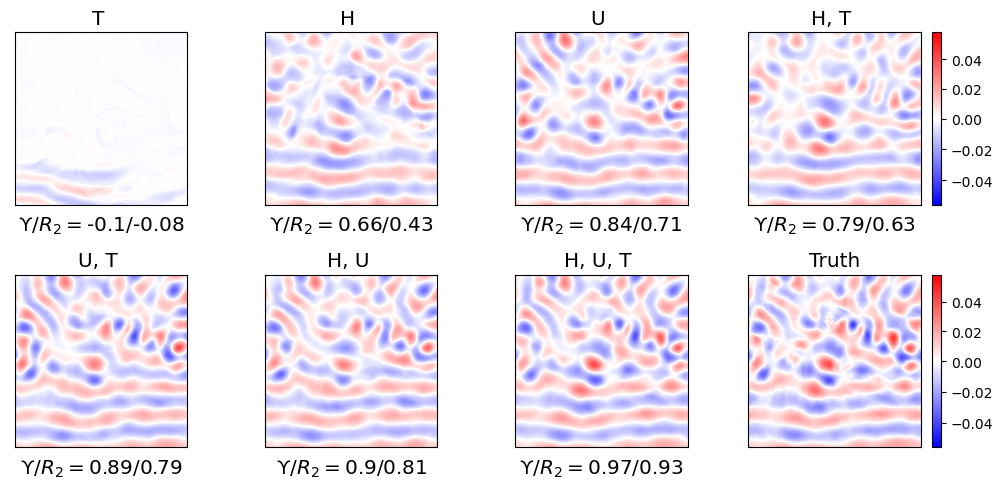

In [40]:
field_max = np.max(outputs_cosssh_HUTcomb)
field_min = np.min(outputs_cosssh_HUTcomb)
truth_snapshot = out_test[snap_index, 0]
model_ordering = ['T', 'H', 'U', 'H, T','U, T', 'H, U', 'H, U, T']
fig=plt.figure(figsize = (10.5,5))
norm = TwoSlopeNorm(vcenter =0)
for i in range(7):
    plt.subplot(2, 4,i+1)
    plt.imshow(outputs_cosssh_HUTcomb[i,snap_index, mid_slice, :], origin ='lower', cmap = ssh_cmap, norm=norm)
#     plt.colorbar()
    plt.clim(field_min, field_max)
    correlation = corr(truth_snapshot[mid_slice, :], outputs_cosssh_HUTcomb[i,snap_index, mid_slice, :])
    coeff_determ = L2_R(truth_snapshot[mid_slice, :], outputs_cosssh_HUTcomb[i,snap_index, mid_slice, :])
    print (correlation)
#     plt.text(40, 20, r'$\mathcal{\Upsilon}$ = ' +  str(round(correlation, 2)), fontsize = 'x-large')
#     plt.text(40, 60, r'$R_2$ = ' +  str(round(coeff_determ, 2)), fontsize = 'x-large')
    plt.xlabel(r'$\mathcal{\Upsilon}/R_2 = $'+ str(round(correlation, 2))+'/'+str(round(coeff_determ, 2)),
               fontsize = 'x-large')
    plt.xticks([])
    plt.yticks([])
    if i==3:
        plt.colorbar()

    plt.title('{} '.format(model_ordering[i]), fontsize = 'x-large')
plt.subplot(2,4,8)
plt.imshow(truth_snapshot[mid_slice, :] , origin ='lower', cmap = ssh_cmap, norm =norm)
plt.colorbar()
plt.title('Truth',  fontsize = 'x-large')
plt.xticks([])
plt.yticks([])
# plt.colorbar()
# plt.title('{} '.format(to_ssh_model_names[i]), fontsize = 'xx-large')
# fig.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

179
180


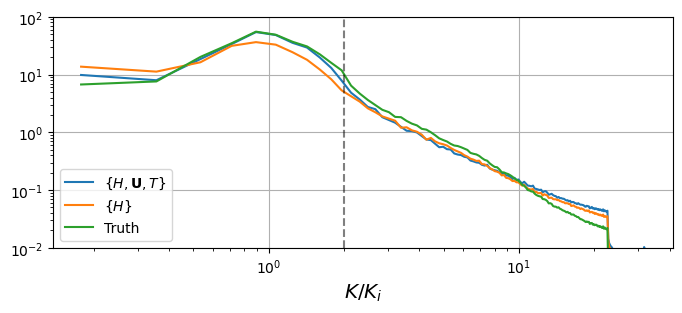

In [41]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.
    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
#     print ('nr', nr)
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr
#     print (radial_prof.shape, 'rad profile shape')

    return radial_prof


def spectrum(image):
    image_fft = fft.fft2(image)
    fshift = fft.fftshift(image_fft) + 1e-10
#     mag_spectrum = np.log(np.abs(fshift))
    mag_spectrum = np.abs(fshift)
    psd1D = azimuthalAverage(mag_spectrum)  
#     psd1D = (psd1D-np.min(psd1D))/(np.max(psd1D)-np.min(psd1D))
    return  psd1D

HUT_wave_mid = HUT_out_mod[snap_index,0, mid_slice, : ]
H_wave_mid = H_out_mod[snap_index,0, mid_slice, : ]
true_wave_mid = out_test[snap_index,0, mid_slice, : ]

smHUT = spectrum(HUT_wave_mid)
smH = spectrum(H_wave_mid)
smTr = spectrum(true_wave_mid)
print (len (smTr))
freq = np.fft.rfftfreq(179*2, d=1)/(2*np.pi/400) #the units here are probably grid spacing (4 km)
print (len(freq))

fig, ax  = plt.subplots(figsize = (8, 3))

plt.plot(freq[1:], smHUT, label = r'$\{H,\mathbf{U},T\}$')
plt.plot(freq[1:], smH, label = r'$\{H\}$')
plt.plot(freq[1:], smTr, label ='Truth')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.01, 100)
#plt.axvline(x=1, c='k', linestyle='-', alpha = 0.5) #, label =r'$x = 2 K_i$'
plt.axvline(x=2, c='k', linestyle='--', alpha = 0.5) #, label =r'$x = 2 K_i$'
plt.grid()
plt.xlabel(r'$K/K_i$', fontsize = 'x-large')
# ellipse = patches.Ellipse((2,10), 10,10, linewidth=1, edgecolor='r', facecolor='none')
plt.legend(loc='lower left')
plt.show()



In [42]:
#Save outputs
modeloutput_dir = '/work/uo0780/u241359/project_tide_synergy/model_outputs/'
np.savez(modeloutput_dir+'HUTcombs_UNet', T_out_mod, H_out_mod, U_out_mod, HT_out_mod, TU_out_mod, HU_out_mod, HUT_out_mod, out_test) 
#npz = np.load('data/temp/np_savez.npz')
#Access the stored arrays by specifying their names within []. The names of each array can be checked using the files attribute.
#print(npz.files)
# ['arr_0', 'arr_1']
#print(npz['arr_0'])
# [0 1 2 3 4]